In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from pathlib import Path
from fastai import collab

### Getting the data

In [3]:
path = Path('data')
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('data')

In [4]:
#!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip -P {path}

In [5]:
#!unzip -q -n {path}/ml-latest-small.zip -d {path}/ml-latest-small
#!rm {path}/ml-latest-small.zip

In [6]:
ratings_df = pd.read_csv(path/'ml-latest-small'/'ml-latest-small'/'ratings.csv')
print(ratings_df.shape)
ratings_df.head()

(100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
userId       100836 non-null int64
movieId      100836 non-null int64
rating       100836 non-null float64
timestamp    100836 non-null int64
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [8]:
ratings_df['userId'].nunique()

610

In [9]:
ratings_df['movieId'].nunique()

9724

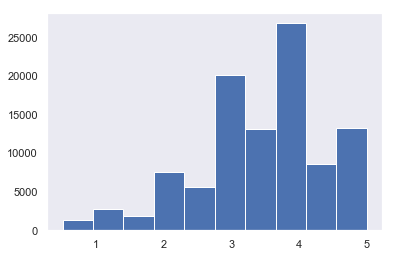

In [10]:
ratings_df['rating'].hist(grid=False);

In [11]:
movies_df = pd.read_csv(path/'ml-latest-small'/'ml-latest-small'/'movies.csv')
print(movies_df.shape)
movies_df.head()

(9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [12]:
movies_df['title'].nunique()

9737

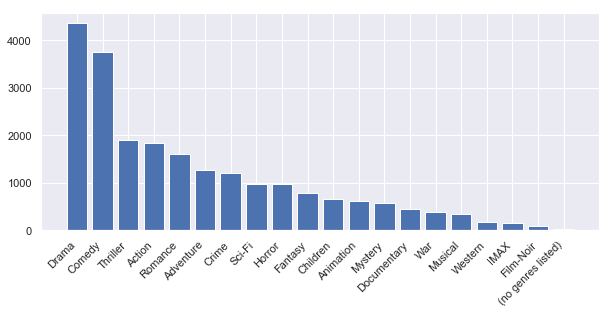

In [13]:
# Discover genre distribution
from collections import Counter

def plot_genre_hist(df, figsize=(10, 4)):
    genre_arrs = df['genres'].map(lambda x: x.split('|') if isinstance(x, str) else [str(np.nan)])
    most_common_genres = Counter([genre for genre_arr in genre_arrs for genre in genre_arr]).most_common()
    plt.figure(figsize=figsize)
    x, y = zip(*most_common_genres)
    plt.bar(x, y)
    plt.xticks(rotation=45, ha="right")
    plt.show()
    
plot_genre_hist(movies_df)

In [14]:
ratings_df = ratings_df.merge(movies_df[['movieId', 'title']])
ratings_df.head()

,userId,movieId,rating,timestamp,title
0,1,1,4.0,964982703,Toy Story (1995)
1,5,1,4.0,847434962,Toy Story (1995)
2,7,1,4.5,1106635946,Toy Story (1995)
3,15,1,2.5,1510577970,Toy Story (1995)
4,17,1,4.5,1305696483,Toy Story (1995)


In [15]:
# Consistency check
(ratings_df.groupby(by='movieId')['title'].unique().map(len) > 1).any()

False

In [16]:
# Establish info maps
genres_map = movies_df.set_index(movies_df['title']).to_dict()['genres']
mean_rating_map = ratings_df.groupby(by='title')['rating'].mean().to_dict()

### Training the model

In [17]:
data = collab.CollabDataBunch.from_df(
    ratings_df,
    seed=42, 
    pct_val=0.1, 
    user_name='userId', 
    item_name='title', 
    rating_name='rating', 
    path=path)

In [18]:
data.show_batch()

userId,title,target
508,Excalibur (1981),1.5
199,"Darjeeling Limited, The (2007)",4.0
288,"Doors, The (1991)",4.0
448,Pirates of the Caribbean: On Stranger Tides (2011),1.5
469,RoboCop (1987),3.0


In [19]:
# Scaled sigmoid function -> give some room for 0.5 and 5
y_range = [0, 5.5]

In [20]:
# The latent features of users and movies are learned with their combinations
learn = collab.collab_learner(data, n_factors=50, y_range=y_range, wd=1e-1)

In [21]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(611, 50)
  (i_weight): Embedding(9352, 50)
  (u_bias): Embedding(611, 1)
  (i_bias): Embedding(9352, 1)
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


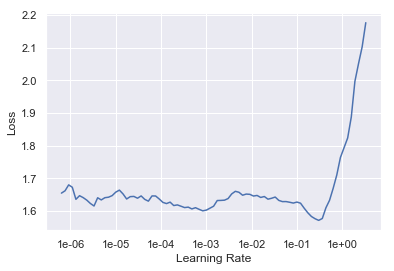

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss
1,1.269198,1.180778
2,0.795182,0.760655
3,0.697625,0.718832
4,0.651698,0.707448
5,0.591766,0.706390


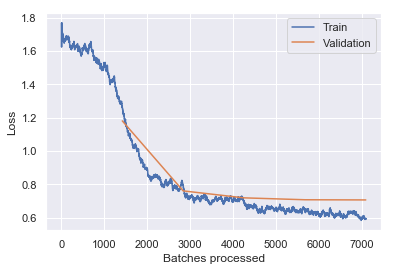

In [24]:
learn.recorder.plot_losses()

In [25]:
learn.save('dotprod')

### Biases

In [26]:
learn.load('dotprod');

In [27]:
# Take only movies with trained embeddings
_, trained_movies = learn.data.classes.values()

# Get top movies by number of ratings
top_movies = (ratings_df[ratings_df['title'].isin(trained_movies)]
              .groupby('title')['rating']
              .count()
              .sort_values(ascending=False)
              .index.values)
len(top_movies)

9351

In [28]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([9351])

In [29]:
mean_ratings = ratings_df.groupby('title')['rating'].mean()
movie_ratings = [(b.detach().numpy(), i, mean_ratings.loc[i]) for i, b in zip(top_movies, movie_bias)]
movie_ratings_df = pd.DataFrame(movie_ratings, columns=['bias', 'title', 'rating'])
movie_ratings_df.head()

,bias,title,rating
0,0.2796578,Forrest Gump (1994),4.164134
1,0.31119484,"Shawshank Redemption, The (1994)",4.429022
2,0.20955747,Pulp Fiction (1994),4.197068
3,0.16240126,"Silence of the Lambs, The (1991)",4.161290
4,0.14870717,"Matrix, The (1999)",4.192446


In [30]:
# Top movies with negative bias
movie_ratings_df.sort_values('bias', ascending=True).head()

,bias,title,rating
2390,-0.13972192,Catwoman (2004),1.333333
1348,-0.13412292,Speed 2: Cruise Control (1997),1.605263
1313,-0.123067595,Battlefield Earth (2000),1.657895
1904,-0.115355186,Dungeons & Dragons (2000),1.833333
782,-0.11436288,Godzilla (1998),1.954545


In [31]:
# Top movies with positive bias
movie_ratings_df.sort_values('bias', ascending=False).head()

,bias,title,rating
1,0.31119484,"Shawshank Redemption, The (1994)",4.429022
0,0.2796578,Forrest Gump (1994),4.164134
44,0.2399297,"Dark Knight, The (2008)",4.238255
13,0.22623758,"Usual Suspects, The (1995)",4.237745
71,0.2229812,Eternal Sunshine of the Spotless Mind (2004),4.160305


### Movie embeddings

In [32]:
rand_idxs = np.random.choice(len(top_movies), 30, replace=False)

In [33]:
movie_weights = learn.weight(top_movies, is_item=True)
movie_weights.shape

torch.Size([9351, 50])

In [34]:
# Cluster the weights of each movie into a lower-dimensional space
# Clustering based on hard maths
movie_pca = movie_weights.pca(2)
movie_pca.shape

torch.Size([9351, 2])

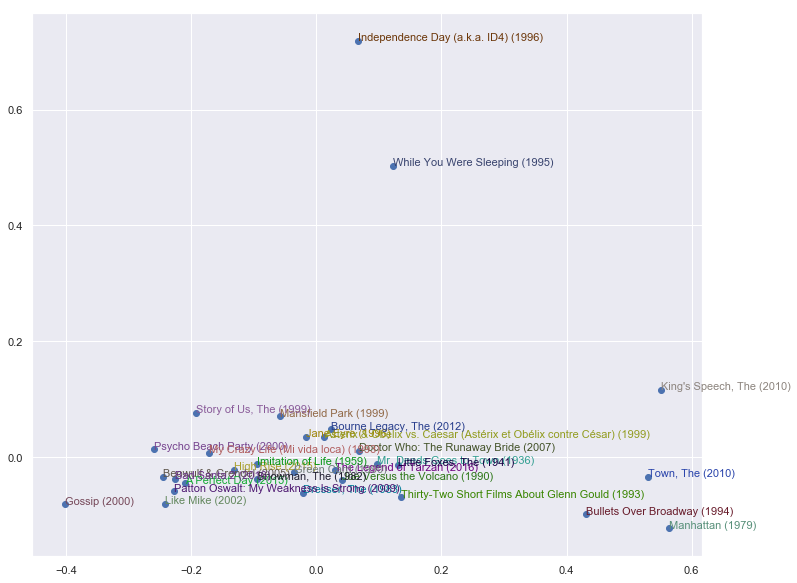

In [35]:
def plot_movies(positions, top_movies):
    plt.figure(figsize=(12, 10))
    plt.scatter(positions[:, 0], positions[:, 1])
    for x, y, i in zip(positions[:, 0], positions[:, 1], top_movies):
        plt.text(x, y, i, color=np.random.rand(3)*0.7, fontsize=11)
    plt.show()
    
plot_movies(movie_pca[rand_idxs], top_movies[rand_idxs])

In [36]:
%%time
# Clustering based on probability distribution
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=20).fit_transform(movie_weights)
tsne.shape

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 9351 samples in 0.021s...
[t-SNE] Computed neighbors for 9351 samples in 7.732s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9351
[t-SNE] Computed conditional probabilities for sample 2000 / 9351
[t-SNE] Computed conditional probabilities for sample 3000 / 9351
[t-SNE] Computed conditional probabilities for sample 4000 / 9351
[t-SNE] Computed conditional probabilities for sample 5000 / 9351
[t-SNE] Computed conditional probabilities for sample 6000 / 9351
[t-SNE] Computed conditional probabilities for sample 7000 / 9351
[t-SNE] Computed conditional probabilities for sample 8000 / 9351
[t-SNE] Computed conditional probabilities for sample 9000 / 9351
[t-SNE] Computed conditional probabilities for sample 9351 / 9351
[t-SNE] Mean sigma: 0.024549
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.414040
[t-SNE] KL divergence after 1000 iterations: 1.936715
CPU times: user 6min 33s, sys: 6.3 s, 

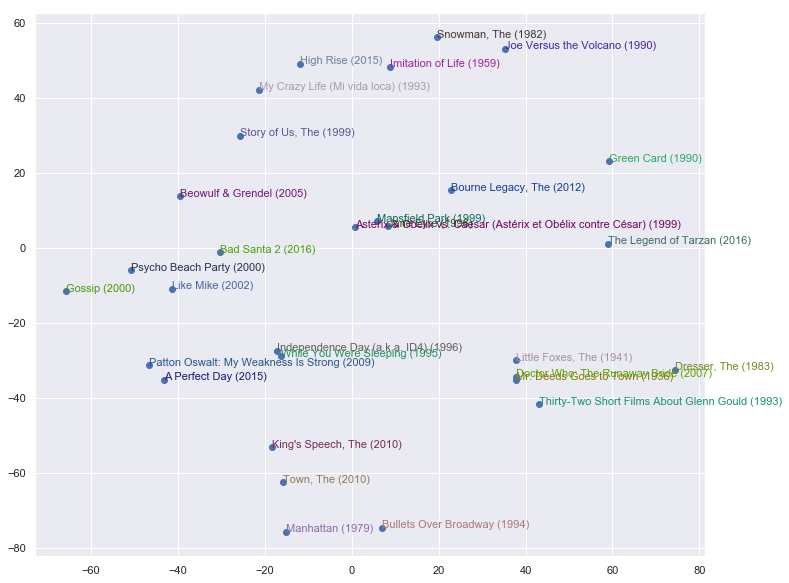

In [37]:
plot_movies(tsne[rand_idxs], top_movies[rand_idxs])

### Similarity-based lookup

In [46]:
# https://arxiv.org/pdf/1704.02552.pdf
from sklearn.metrics.pairwise import cosine_similarity

def compute_similarity_matrix(is_item):
    trained_users, trained_movies = learn.data.classes.values()
    embeddings = learn.weight(trained_movies if is_item else trained_users, is_item=is_item)
    return cosine_similarity(embeddings, embeddings)
    
movie_sim_matrix = compute_similarity_matrix(True)
movie_sim_matrix.shape

(9352, 9352)

In [55]:
def embedding_knn(sim_matrix, sources, is_item, k=10):
    # kNN involving item-item or user-user relationships
    # Set diagonal to zero
    sim_matrix = sim_matrix.copy()
    np.fill_diagonal(sim_matrix, 0)
    
    # Reduce the similarity matrix to the relevant embeddings
    if not isinstance(sources, list):
        sources = [sources]
    source_idxs = learn.get_idx(map(str, sources), is_item=is_item)
    sim_matrix = sim_matrix[source_idxs]
    
    # Get indices of top k embeddings in descending order
    top_idxs = np.argsort(-sim_matrix, axis=None)[:k]
    top_idxs = np.unravel_index(top_idxs, sim_matrix.shape)
    if len(sources) == 1:
        top_idxs = [0] * k, top_idxs[0]
        sim_matrix = np.expand_dims(sim_matrix, 0)
    
    # Return the names and the similarity score
    user_list, item_list = learn.data.classes.values()
    lst = item_list if is_item else user_list
    return [(lst[source_idxs[i]], lst[j], sim_matrix[i, j]) for i, j in list(zip(*top_idxs))]
    
embedding_knn(movie_sim_matrix, ['Matrix, The (1999)'], True)

[('Matrix, The (1999)', 'Saving Private Ryan (1998)', 0.9746928),
 ('Matrix, The (1999)', 'Gladiator (1992)', 0.9732478),
 ('Matrix, The (1999)', 'Gladiator (2000)', 0.97292066),
 ('Matrix, The (1999)',
  'Legend of Drunken Master, The (Jui kuen II) (1994)',
  0.9727827),
 ('Matrix, The (1999)', 'Heat (1995)', 0.9722508),
 ('Matrix, The (1999)',
  'Captain America: The Winter Soldier (2014)',
  0.9712364),
 ('Matrix, The (1999)', 'X-Men: Days of Future Past (2014)', 0.9706926),
 ('Matrix, The (1999)', 'Kung Pow: Enter the Fist (2002)', 0.96962523),
 ('Matrix, The (1999)', 'Dark Knight Rises, The (2012)', 0.9690965),
 ('Matrix, The (1999)', 'River Runs Through It, A (1992)', 0.9686826)]

In [51]:
user_sim_matrix = compute_similarity_matrix(False)
user_sim_matrix.shape

(611, 611)

In [56]:
embedding_knn(user_sim_matrix, [1], False)

[('1', '356', 0.98820496),
 ('1', '171', 0.9854273),
 ('1', '95', 0.98508006),
 ('1', '572', 0.9847678),
 ('1', '253', 0.98457944),
 ('1', '444', 0.98456526),
 ('1', '124', 0.9826653),
 ('1', '595', 0.9817308),
 ('1', '499', 0.9809239),
 ('1', '70', 0.980737)]

In [57]:
get_favorites(1).head()

,userId,title,genres,bias,mean_rating,rating
16250,1,M*A*S*H (a.k.a. MASH) (1970),Comedy|Drama|War,0.119473,3.934783,5.0
14053,1,Excalibur (1981),Adventure|Fantasy,0.028922,3.640000,5.0
9066,1,Indiana Jones and the Last Crusade (1989),Action|Adventure,0.143274,4.046429,5.0
9206,1,Pink Floyd: The Wall (1982),Drama|Musical,0.083758,3.760870,5.0
14254,1,From Russia with Love (1963),Action|Adventure|Thriller,0.089289,3.750000,5.0


In [58]:
get_favorites(356).head()

,userId,title,genres,bias,mean_rating,rating
97253,356,Son of Rambow (2007),Children|Comedy|Drama,0.054673,4.666667,5.0
55909,356,Zack and Miri Make a Porno (2008),Comedy|Drama|Romance,0.067104,3.523810,5.0
77211,356,Tootsie (1982),Comedy|Romance,0.028869,3.421875,5.0
62886,356,Time Bandits (1981),Adventure|Comedy|Fantasy|Sci-Fi,0.085015,3.731707,5.0
34093,356,Dead Poets Society (1989),Drama,0.150072,3.959302,5.0


### Movie recommendation

In [38]:
def get_favorites(user_id):
    # Get favorite movies of the user
    fav_df = ratings_df.loc[ratings_df['userId'] == user_id, ['userId', 'title', 'rating']]
    fav_df['mean_rating'] = fav_df['title'].map(mean_rating_map)
    fav_df['genres'] = fav_df['title'].map(genres_map)
    fav_df['bias'] = learn.bias(fav_df['title'], is_item=True).detach().numpy()
    fav_df = fav_df[['userId', 'title', 'genres', 'bias', 'mean_rating', 'rating']]
    return fav_df.sort_values(by='rating', ascending=False)

user_id = 1
favorites_df = get_favorites(user_id)
favorites_df.head()

,userId,title,genres,bias,mean_rating,rating
16250,1,M*A*S*H (a.k.a. MASH) (1970),Comedy|Drama|War,0.119473,3.934783,5.0
14053,1,Excalibur (1981),Adventure|Fantasy,0.028922,3.640000,5.0
9066,1,Indiana Jones and the Last Crusade (1989),Action|Adventure,0.143274,4.046429,5.0
9206,1,Pink Floyd: The Wall (1982),Drama|Musical,0.083758,3.760870,5.0
14254,1,From Russia with Love (1963),Action|Adventure|Thriller,0.089289,3.750000,5.0


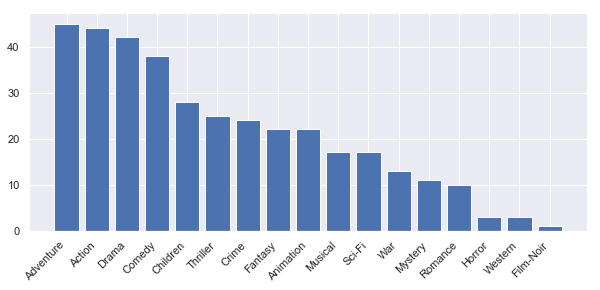

In [39]:
plot_genre_hist(favorites_df[favorites_df['rating'] > 4])

In [40]:
def get_unseen_movies(user_id):
    # Get the list of unseen movies
    _, trained_movies = learn.data.classes.values()
    seen_movies = ratings_df.loc[ratings_df['userId'] == user_id, 'title'].unique()
    unseen_movies = set(trained_movies).difference(set(seen_movies))
    return list(unseen_movies)

def recommend_to_user(user_id):
    # Predict favorite movies for the user
    unseen_movies = get_unseen_movies(user_id)
    u = learn.get_idx([str(user_id)] * len(unseen_movies), is_item=False)
    m = learn.get_idx(unseen_movies, is_item=True)
    pred = learn.model.eval().cpu()(u, m)
    
    # Build dataframe
    pred_df = pd.DataFrame({'userId': user_id, 'title': unseen_movies})
    pred_df['genres'] = pred_df['title'].map(genres_map)
    pred_df['bias'] = learn.bias(pred_df['title'], is_item=True).detach().numpy()
    pred_df['mean_rating'] = pred_df['title'].map(mean_rating_map)
    pred_df['rating'] = pred
    return pred_df.sort_values(by='rating', ascending=False)

pred_df = recommend_to_user(user_id)
pred_df.head()

,userId,title,genres,bias,mean_rating,rating
5910,1,"Shawshank Redemption, The (1994)",Crime|Drama,0.311195,4.429022,5.144051
1928,1,"Godfather, The (1972)",Crime|Drama,0.170974,4.289062,5.101264
1109,1,Wallace & Gromit: The Best of Aardman Animatio...,Adventure|Animation|Comedy,0.125220,4.092593,5.046701
15,1,Lawrence of Arabia (1962),Adventure|Drama|War,0.146328,4.300000,5.036444
7176,1,"Godfather: Part II, The (1974)",Crime|Drama,0.144859,4.259690,5.032229


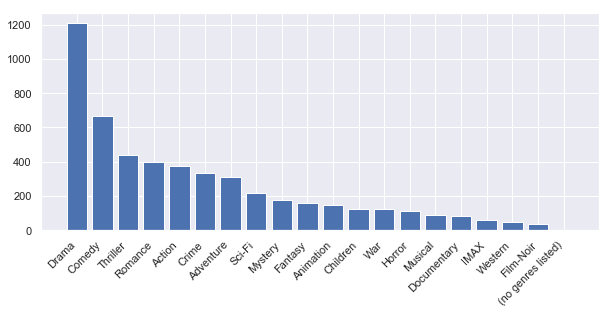

In [41]:
plot_genre_hist(pred_df[pred_df['rating'] > 4])

Keep in mind the following drawbacks:

- it doesn't address the well-known cold-start problem, that is when new user or new item enters the system
- it can't deal with sparse data, meaning it's hard to find users that have rated the same items
- it tends to recommend popular items.